# A Machine Learning Approach to Equity Premium Prediction
By Shane Johnson (ND CS), Catherine Markley (ND CS), Yuanhao Niu (ND Econ), Nick Rocco (ND CS) 
<br>-- Fall 2018 CSE 40647/60647 Data Science Project

## Introduction
We try to use machine learning methods to predict equity premium based on predictors from the seminal paper of Goyal and Welch (2008). 

We first build and clean our dataset. Then we try to predict bull/bear market as a classification job. Portfolio based on the prediction were constructed accordingly. In a parallel task, we use different regression approaches to predict equity premium. Our models outperforme the historical average forecast. 

## Data Cleaning

Raw data are downloaded from Prof. Goyal's webside. We included their orginal monthly data from 1926/12 to 2013/12.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("raw_predictors_until2013.csv")

Generate the predictors based on the raw data, as in Welch and Goyal (2008)

In [2]:
# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['CRSP_SPvw'] - df['Rfree']

# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices. 
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated cor- porate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
df['dfr'] = df['corpr'] - df['ltr']

In [3]:
# drop the first observation for 1926/12
df = df[1:]

We generate indicators for bull market.

In [4]:
sLength = len(df['yyyymm'])
# add the bullMarket column with random ints (to be replaced in next cell)
df['bull'] = pd.Series(np.random.randn(sLength), index=df.index)
# Create bullMarkert for ret
bull = []
for d in df['CRSP_SPvw']:
    if d > 0:
        bull.append(1)
    else:
        bull.append(0)
df['bull'] = bull

In [5]:
# drop the redundent variables
df = df.drop(columns=['Index','D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

In [6]:
# The Cross-Sectional Premium (csp) was only available from May 1937 to December 2002. 
# We compute the average of the data and fill the missing values with the average value.
pd.options.mode.chained_assignment=None
df['csp'][0:124] = df['csp'][124:911].mean()
df['csp'][912:]  = df['csp'][124:911].mean()

In [7]:
premium = 0
count = 0

temp = df['premium']

his_avg = []

for i in temp:
    premium += i
    count += 1
    his_avg.append(premium/count)

df['his_avg'] = his_avg

Now we had the clean dataset to work on!

In [8]:
# reorganize the dataframe
df = df[['yyyymm','Month','his_avg','bull','premium','d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl']]
df

,yyyymm,Month,his_avg,bull,premium,d/p,d/y,e/p,d/e,svar,csp,b/m,ntis,tbl,lty,ltr,tms,dfy,dfr,infl
1,192701,1,-0.005602,0,-0.005602,-2.942374,-2.963349,-2.374773,-0.567601,0.000470,0.00037,0.443706,0.050834,0.0323,0.0351,0.0075,0.0028,0.0095,-0.0019,-0.011299
2,192702,2,0.018589,1,0.042780,-2.979535,-2.932946,-2.430353,-0.549182,0.000287,0.00037,0.428501,0.051682,0.0329,0.0347,0.0088,0.0018,0.0092,-0.0019,-0.005714
3,192703,3,0.013945,1,0.004657,-2.976535,-2.970053,-2.445079,-0.531456,0.000924,0.00037,0.469765,0.046370,0.0320,0.0331,0.0253,0.0011,0.0092,-0.0170,-0.005747
4,192704,4,0.013008,1,0.010196,-2.984225,-2.967143,-2.471309,-0.512916,0.000603,0.00037,0.456754,0.050518,0.0339,0.0333,-0.0005,-0.0006,0.0090,0.0060,0.000000
5,192705,5,0.022322,1,0.059578,-3.025963,-2.975058,-2.531446,-0.494518,0.000392,0.00037,0.434783,0.055279,0.0333,0.0327,0.0109,-0.0006,0.0093,-0.0120,0.005780
6,192706,6,0.014780,0,-0.022928,-3.007309,-3.016743,-2.531330,-0.475979,0.000825,0.00037,0.452385,0.058826,0.0307,0.0334,-0.0069,0.0027,0.0097,0.0112,0.011494
7,192707,7,0.024381,1,0.081983,-3.061144,-2.998173,-2.603707,-0.457437,0.000426,0.00037,0.414553,0.059754,0.0296,0.0333,0.0050,0.0037,0.0095,-0.0047,-0.017045
8,192708,8,0.025217,1,0.031070,-3.095764,-3.052225,-2.656742,-0.439023,0.001276,0.00037,0.396227,0.054526,0.0270,0.0329,0.0076,0.0059,0.0092,0.0007,-0.005780
9,192709,9,0.028058,1,0.050783,-3.129097,-3.086791,-2.707759,-0.421338,0.001123,0.00037,0.380586,0.094617,0.0268,0.0330,0.0018,0.0062,0.0088,0.0131,0.005814
10,192710,10,0.020315,0,-0.049371,-3.065650,-3.120203,-2.662875,-0.402774,0.001559,0.00037,0.413801,0.094370,0.0308,0.0325,0.0099,0.0017,0.0087,-0.0044,0.005780


Plot the heatmap of feature correlation

In [9]:
features = df[['premium','d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl']]

corr = features.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We recognize the autocorrelation in time series. In order to take full advantage of the past information, we include the past 20 years' data in the prediction. Here we generate predictors for the past 20 years, i.e. 240 months

In [10]:
past = 241

num = len(df.columns)
for i in range(4,num):
    name = df.columns[i]
    for j in range(1,past):
        t = str(j)
        df[name+"-"+t] = df[name].shift(j)

In [11]:
# drop the first past 20 years predictors
df = df[past-1:]

In [12]:
# drop the contemporanous predictors
df = df.drop(columns=['d/p','d/y','e/p','d/e','svar',
          'csp','b/m','ntis','tbl','lty','ltr','tms','dfy','dfr','infl'])

In [13]:
# column number 3845: 'yyyymm','Month',‘his_avg’，'bull','premium' + 16 indicator * 240 months 
len(df.columns)

3845

Here we plot the distribution of the equity premium. The returns are left-skewed (i.e. negative skewness).

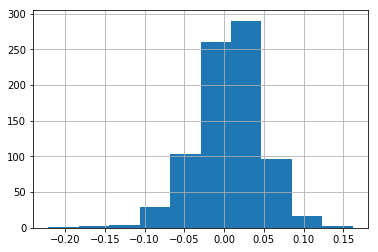

In [14]:
hist = df["premium"].hist(bins=10)

## Classification (Bull Market Prediction)

For classification purpose, we first normalize the features 

In [15]:
bull = df.bull
x = df.iloc[:,5:]
norm_x = (x- x.mean())/x.std(ddof=0)

We use the first half as training data and the second half as testing data

In [16]:
norm_x_train = norm_x[0:int(len(norm_x)/2)]
norm_x_test = norm_x[int(len(norm_x)/2):]
bull_train = bull[0:int(len(bull)/2)]
bull_test = bull[int(len(bull)/2):]

Decision tree (CART algorithm)

In [17]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


clf = tree.DecisionTreeClassifier()
clf = clf.fit(norm_x_train, bull_train)
predicted = clf.predict(norm_x_test)
c_matrix = confusion_matrix(predicted,bull_test)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: " ,"\n" , c_matrix)  

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix:  
 [[103 160]
 [ 45  94]]
precision:  0.3701
recall:  0.6763


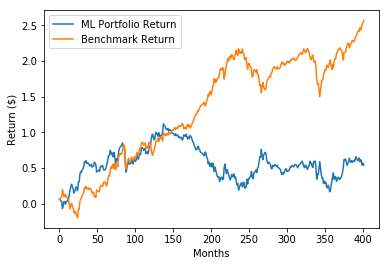

In [18]:
temp = df['premium']
premium = temp[int(len(temp)/2):]
cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(int(len(predicted))):
    if predicted[i] == 1:
        cumsum += premium[i+643]
    else:
        cumsum += -1*premium[i+643]
        # unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+643]
    cs_h.append(cumsum_h)
    
plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

Naive Bayes 

In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(norm_x_train,bull_train).predict(norm_x_test)

predicted= gnb.predict(norm_x_test)

c_matrix = confusion_matrix(predicted,bull_test)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: ""\n" , c_matrix)  

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix: 
 [[136 231]
 [ 12  23]]
precision:  0.0906
recall:  0.6571


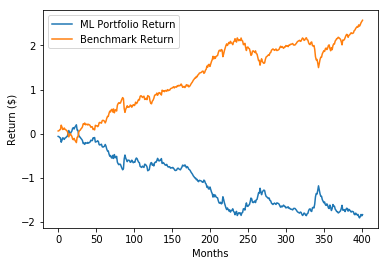

In [20]:
temp = df['premium']
premium = temp[int(len(temp)/2):]

cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(len(predicted)):
    if predicted[i] == 1:
        cumsum += premium[i+643]
    else:
        cumsum += -1*premium[i+643]
        # unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+643]
    cs_h.append(cumsum_h)
    
plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

Support Vector Classification

In [21]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(norm_x_train, bull_train) 

predicted= clf.predict(norm_x_test)

c_matrix = confusion_matrix(predicted,bull_test)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: ""\n" , c_matrix)  

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix: 
 [[  0   0]
 [148 254]]
precision:  1.0
recall:  0.6318


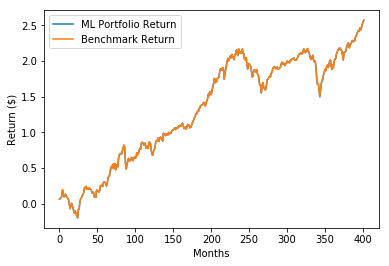

In [22]:
temp = df['premium']
premium = temp[int(len(temp)/2):]

cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(len(predicted)):
    if predicted[i] == 1:
        cumsum += premium[i+643]
    else:
        cumsum += -1*premium[i+643]
        # unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+643]
    cs_h.append(cumsum_h)


plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

K-Means (K=10)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(norm_x_train, bull_train)
predicted= clf.predict(norm_x_test)

c_matrix = confusion_matrix(predicted,bull_test)
precision = c_matrix[1,1]/(c_matrix[1,1]+c_matrix[0,1])
recall= c_matrix[1,1]/(c_matrix[1,1]+c_matrix[1,0])

print("Confusion Matrix: ""\n" , c_matrix)    

print("precision: ", round(precision,4))  
print("recall: ", round(recall,4))  

Confusion Matrix: 
 [[ 72 150]
 [ 76 104]]
precision:  0.4094
recall:  0.5778


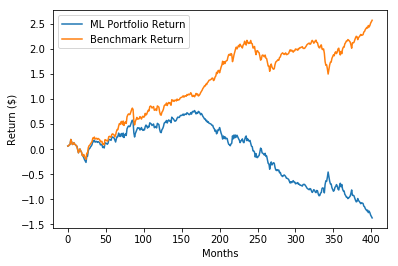

In [24]:
temp = df['premium']
premium = temp[int(len(temp)/2):]

cumsum = 0
cs = []

cumsum_h = 0
cs_h = []

for i in range(len(predicted)):
    if predicted[i] == 1:
        cumsum += premium[i+643]
    else:
        cumsum += -1*premium[i+643]
        # unblock the above two lines to impose short-selling constraint
    cs.append(cumsum)

for i in range(len(bull_test)):
    cumsum_h += premium[i+643]
    cs_h.append(cumsum_h)
    
plt.figure()
plt.plot(cs, label='ML Portfolio Return')
plt.plot(cs_h, label='Benchmark Return')
plt.legend(loc='best')
plt.ylabel('Return ($)')
plt.xlabel('Months')
plt.show()

## Regression (Equity Premium Prediction)

In [25]:
ret = df.premium
x = df.iloc[:,4:]

We will first start with the simplest linear regression model. 

In [26]:
# Here are 67 years of data prior to 2013 
# Spilt the data into 7 folds and cross-validate
# In each sample we have around 10 years of data

pd.options.mode.chained_assignment=None
import math
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.cross_validation import KFold

kf = KFold(x.shape[0],n_folds=7, shuffle=True)


diff_MAE = []
diff_RMSE = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]

    regr = linear_model.LinearRegression()
    regr.fit(x_train, ret_train)

    ret_pred = regr.predict(x_test)

    
    diff = df['his_avg'].iloc[test_index] - df['premium'].iloc[test_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(test_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    print("MAE of regression: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4))

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


MAE of regression:  0.008139257670068654
MAE of hist average:  0.005967077244222139
Diff MAE:  -0.0021721804258465144
RMSE of regression:  0.00010974143765709608
RMSE of hist average:  0.04538336138836262
Diff RMSE:  0.04527361995070552
adjusted R2: 1.0016458095621676
-------------------------------------------------------------------
MAE of regression:  0.009076796483323444
MAE of hist average:  0.0048072416640618015
Diff MAE:  -0.004269554819261642
RMSE of regression:  0.00013099177775512282
RMSE of hist average:  0.03574843789693553
Diff RMSE:  0.035617446119180406
adjusted R2: 1.0031376824131917
-------------------------------------------------------------------
MAE of regression:  0.007278778637328344
MAE of hist average:  0.005131557099969633
Diff MAE:  -0.002147221537358711
RMSE of regression:  8.039058002883786e-05
RMSE of hist average:  0.03877979957079306
Diff RMSE:  0.038699408990764225
adjusted R2: 1.0016324863910173
---------------------------------------------------------

Random Forrest

In [27]:
pd.options.mode.chained_assignment=None
from sklearn.ensemble import RandomForestRegressor

diff_MAE = []
diff_RMSE = []
in_sample = []
out_sample = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]
    
    regr = RandomForestRegressor(max_depth=25, random_state=0, n_estimators=25)
    regr.fit(x_train, ret_train)
    
    ret_pred = regr.predict(x_test)
    ret_fit = regr.predict(x_train)
    
    diff = df['his_avg'].iloc[test_index] - df['premium'].iloc[test_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(test_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    in_sample.append(mean_absolute_error(ret_train, ret_fit))
    out_sample.append(mean_absolute_error(ret_test, ret_pred))
    
    print("MAE of regression_in: ", mean_absolute_error(ret_train, ret_fit))
    print("MAE of regression_out: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4), 
      "In-sample avg: ", round(sum(in_sample)/len(in_sample),4),
      "Out-sample avg: ", round(sum(out_sample)/len(out_sample),4))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


MAE of regression_in:  0.0004874428330948461
MAE of regression_out:  0.0010285027668119964
MAE of hist average:  0.005967077244222139
Diff MAE:  0.004938574477410143
RMSE of regression:  6.773341875569072e-06
RMSE of hist average:  0.04538336138836262
Diff RMSE:  0.045376588046487046
adjusted R2: 1.0001015808710423
-------------------------------------------------------------------
MAE of regression_in:  0.0004992558764125016
MAE of regression_out:  0.0005136758113188427
MAE of hist average:  0.0048072416640618015
Diff MAE:  0.004293565852742959
RMSE of regression:  1.098094426671324e-06
RMSE of hist average:  0.03574843789693553
Diff RMSE:  0.035747339802508854
adjusted R2: 1.0000263029606105
-------------------------------------------------------------------
MAE of regression_in:  0.0005191805655776694
MAE of regression_out:  0.0010101501052685626
MAE of hist average:  0.005131557099969633
Diff MAE:  0.004121406994701071
RMSE of regression:  1.2640955339396041e-05
RMSE of hist averag

We plot in-sample and out-of sample prediction errors to decide max_depth

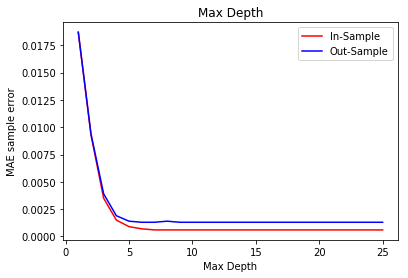

In [28]:
# n_estimators = 10
# Varying max_depth
import matplotlib.pyplot as plt

depths = list(np.arange(1, 13))
depths.append(25)
in_sample = [0.0187, 0.0093, 0.0035, 0.0015, 0.0009, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006]
out_sample = [0.0187, 0.0094, 0.0039, 0.0019, 0.0014, 0.0013, 0.0013, 0.0014, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013]

plt.plot(depths, in_sample, 'r-')
plt.plot(depths, out_sample, 'b-')
plt.title("Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("MAE sample error")
plt.legend(["In-Sample", "Out-Sample"])
plt.show()

Boosted Trees

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

diff_MAE = []
diff_RMSE = []

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    ret_train, ret_test = ret.iloc[train_index], ret.iloc[test_index]
    
    regr = GradientBoostingRegressor(n_estimators=25, learning_rate=0.5, max_depth=25, random_state=0, loss='ls')
    regr.fit(x_train, ret_train)
    
    ret_pred = regr.predict(x_test)
    
    diff = df['his_avg'].iloc[train_index] - df['premium'].iloc[train_index]
    mae_avg = diff.abs().sum() / len(train_index)
    diff_MAE.append(mae_avg - mean_absolute_error(ret_test, ret_pred))
    rmse_avg = math.sqrt(np.power(diff, 2).sum() / len(train_index))
    diff_RMSE.append(rmse_avg - mean_squared_error(ret_test, ret_pred))

    r_squared = r2_score(ret_test, ret_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(ret_test)-1)/(len(ret_test)-x_test.shape[1]-1)
    
    print("MAE of regression: ", mean_absolute_error(ret_test, ret_pred))
    print("MAE of hist average: ", mae_avg)
    print("Diff MAE: ", mae_avg - mean_absolute_error(ret_test, ret_pred))
    print("RMSE of regression: ", mean_squared_error(ret_test, ret_pred))
    print("RMSE of hist average: ", rmse_avg)
    print("Diff RMSE: ", rmse_avg - mean_squared_error(ret_test, ret_pred))
    print("adjusted R2:", adjusted_r_squared)
    print("-------------------------------------------------------------------")
    
print( "the main take way: Mean(Diff_MAE) is", round(sum(diff_MAE)/len(diff_MAE),4),
      "Mean(Diff_RMSE) is", round(sum(diff_RMSE)/len(diff_RMSE),4))

MAE of regression:  0.0010243971489092378
MAE of hist average:  0.03150774547737218
Diff MAE:  0.03048334832846294
RMSE of regression:  9.6530245807647e-06
RMSE of hist average:  0.04129263027300517
Diff RMSE:  0.041282977248424405
adjusted R2: 1.0001447679244782
-------------------------------------------------------------------
MAE of regression:  0.0005450083379825306
MAE of hist average:  0.032667581057532515
Diff MAE:  0.032122572719549984
RMSE of regression:  8.439999564918578e-07
RMSE of hist average:  0.04284336025747834
Diff RMSE:  0.04284251625752185
adjusted R2: 1.0000202165652348
-------------------------------------------------------------------
MAE of regression:  0.0007644349318858612
MAE of hist average:  0.032343265621624685
Diff MAE:  0.031578830689738824
RMSE of regression:  2.5630340298733544e-06
RMSE of hist average:  0.042401004641728315
Diff RMSE:  0.04239844160769844
adjusted R2: 1.000052047368883
-----------------------------------------------------------------